In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Program name

AS_pavloviantask_v2

### Variable Definitions

- D   = event time stamp
- E   = event identity stamp

### Event Stamps

#### Trial bits
- 5   = Pellet reinforcement delivery
- 22  = CS on
- 23  = CS off
- 15  = ITI starts
- 16  = ITI ends

#### within bits
- 1   = Rt lever press/NP
- 2   = Lt lever press/NP
- 6   = Food tray head entry
- 24  = Food tray head entry during CS
- 26  = Right lever press during CS
- 27  = Left lever press during CS

#### ITI bits
- 1   = Rt lever press/NP
- 2   = Lt lever press/NP
- 6   = Food tray head entry
- 25  = Food tray head entry during ITI
- 28  = Right lever press during ITI
- 29  = Left lever press during ITI

#### remainder
- 7   = Right cue light on
- 8   = Left cue light on
- 9   = Right cue light off
- 10  = Left cue ight off
- 11  = Magazine tray light on
- 12  = Magazine tray light off
- 13  = Liquid delivery turns on
- 14  = Liquid delivery turns off
- 18  = Right lever extends
- 19  = Left lever extends
- 20  = Right lever retracts
- 21  = Left lever retracts
- 100 = Session termination


### Functions

In [2]:
def get_file_info_common(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = int(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [3]:
def make_array_from_path(file_path_name):
    # takes in path, creates array (each row of array is a row from original med file)
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(event_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        elif re.search(time_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        else:
            i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times_PCA(es_et, trial_start, trial_end, ITI_start, ITI_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for start and end of trial segment
    #e.g. conditioned stimulus onset and offset, ITI onset and offset
    #finds time_stamps for each start and end, puts into new dataframe

    start_time = es_et[es_et.event_stamp == trial_start]['time_stamp'].values
    end_time = es_et[es_et.event_stamp == trial_end]['time_stamp'].values
    start_time_ITI = es_et[es_et.event_stamp == ITI_start]['time_stamp'].values
    end_time_ITI = es_et[es_et.event_stamp == ITI_end]['time_stamp'].values
    
    cs_iti = pd.DataFrame(data = [start_time, end_time, start_time_ITI[1:len(start_time)], end_time_ITI[1:len(start_time)]])
    cs_iti = cs_iti.T
    cs_iti.columns = ['trial_start', 'trial_end', 'ITI_start', 'ITI_end']
    
    return cs_iti


In [6]:
def create_trial_df(events_and_times, trial_times, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'ITI':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['ITI_start'][i]) & (events_and_times['time_stamp'] <= trial_times['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = trial_times['ITI_start'][i]
            data['ITI_end'] = trial_times['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'within':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = trial_times['trial_start'][i]
            data['trial_end'] = trial_times['trial_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    
    return trial_data

In [7]:
#functions for analysis params

def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

def latency_PCA(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0])
                latency_ave.append((data['time_stamp'] - data['ITI_start']).values.mean())
            elif trial_type == 'within':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0])
                latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean())
        i = i + 1
    
    return latency_1st, latency_ave

In [8]:
def create_session_df_PCA(trial_data, event_dic, trial_type):
    #use trial_data to compute selected parameters (from event_dic)
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T
    elif trial_type == 'within':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        if trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])
        elif trial_type == 'within':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency_PCA(trial_data, event, trial_type)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Get data 

#### Get animal info

In [9]:
#read animal info (lever assignment, group etc) into df

path_animal_info = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/round12_meta.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

print(animal_info.shape)
animal_info.head()

(48, 4)


,animal,cage,group,lever
0,1215,SA319,4,right
1,1216,SA319,4,right
2,1217,SA319,4,right
3,1236,SA326,5,right
4,1237,SA326,5,right


#### Get data path info

In [10]:
path_1 = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA'
session_list_1 = os.listdir(path_1)

file_paths = []
for file in session_list_1:
    file_path = path_1 + '/' + file
    file_paths.append(file_path)
    
print(len(file_paths))
file_paths[0]

211


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_3_1116_201216'

### Compute trials data

In [11]:
%%time
final_data = pd.DataFrame()

bit_dic = {'right_lever': 26, 'left_lever': 27, 'HE': 24}
ITI_dic = {'right_lever': 28, 'left_lever': 29, 'HE': 25}

for file in file_paths:

    print(file) 
    
    if file.split('/')[-1] == '.DS_Store':
        continue
        
    #proccess file
    task, session, animal, date = get_file_info_common(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E:", "T:")
    trial_times = get_trial_times_PCA(events_and_times, 22, 5, 15, 16)
    trial_data = create_trial_df(events_and_times, trial_times, 'within')
    ITItrial_data = create_trial_df(events_and_times, trial_times, 'ITI')
    session_data = create_session_df_PCA(trial_data, bit_dic, 'within')
    ITIsession_data = create_session_df_PCA(ITItrial_data, ITI_dic, 'ITI')

    #get animal metadata
    active_lever = animal_info[animal_info['animal'] == int(animal)]['lever'].iloc[0]
    group = int(animal_info[animal_info['animal'] == int(animal)]['group'])
    cage = animal_info[animal_info['animal'] == int(animal)]['cage'].iloc[0]
    
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])
    session_data['part'] = ['within']*(session_data.shape[0]) 
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['active_lever'] = [active_lever]*(session_data.shape[0])
    session_data['group'] = [group]*(session_data.shape[0])
    session_data['cage'] = [cage]*(session_data.shape[0])
    
    session_data = session_data[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'trial_num', 'trial_duration',
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'right_lever_latency_ave', 'left_lever_latency_ave']]
    
    #create pandas tidy df for within ITI
    ITIsession_data['task'] = [task]*(ITIsession_data.shape[0]) 
    ITIsession_data['part'] = ['ITI']*(ITIsession_data.shape[0]) 
    ITIsession_data['date'] = [date]*(ITIsession_data.shape[0])
    ITIsession_data['animal'] = [animal]*(ITIsession_data.shape[0])
    ITIsession_data['session'] = [session]*(ITIsession_data.shape[0])
    ITIsession_data['active_lever'] = [active_lever]*(ITIsession_data.shape[0])
    ITIsession_data['group'] = [group]*(ITIsession_data.shape[0])
    ITIsession_data['cage'] = [cage]*(ITIsession_data.shape[0])
    
    ITIsession_data = ITIsession_data[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'trial_num', 'trial_duration',
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'right_lever_latency_ave', 'left_lever_latency_ave']]

    #add to final data frame
    data_int = pd.concat([session_data, ITIsession_data], axis = 0, ignore_index=True)
    if final_data.shape[0] == 0:
        final_data = data_int
    else:
        final_data = pd.concat([final_data, data_int], axis = 0, ignore_index=True)

final_data.tail()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_3_1116_201216
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_2_1118_201215
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_6_1215_210322
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_7_1216_210323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_5_1238_210319
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_6_1223_210322
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_6_1240_210322
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_2_1122_201215
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_3_1120_

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_2_1124_201215
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_4_1223_210318
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_4_1240_210318
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_2_1136_201215
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_3_1145_201216
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_3_1138_201216
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_1_1143_201214
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_1_1120_201214
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_6_1

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_7_1215_210323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_6_1216_210322
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_2_1117_201215
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_3_1119_201216
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_6_1121_201221
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_3_1240_210317
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_4_1138_201217
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCA_3_1223_210317
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PCA/PCAAQ_4_114

,task,part,date,session,cage,animal,group,active_lever,trial_num,trial_duration,HE_count,HE_latency_1st,HE_latency_ave,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,right_lever_latency_ave,left_lever_latency_ave
10285,PCAAQ,ITI,201215,2,288,1144,5,left,19,90.0,2,1.16,44.565000,0,NaN,0,NaN,NaN,NaN
10286,PCAAQ,ITI,201215,2,288,1144,5,left,20,60.0,2,5.46,8.050000,0,NaN,0,NaN,NaN,NaN
10287,PCAAQ,ITI,201215,2,288,1144,5,left,21,90.0,6,3.15,18.371667,0,NaN,0,NaN,NaN,NaN
10288,PCAAQ,ITI,201215,2,288,1144,5,left,22,40.0,1,2.47,2.470000,0,NaN,0,NaN,NaN,NaN
10289,PCAAQ,ITI,201215,2,288,1144,5,left,23,80.0,3,2.26,40.183333,0,NaN,0,NaN,NaN,NaN


In [51]:
#make new df with combined data
df_final = final_data.copy()

final_data_trials = pd.DataFrame()

animals = df_final['animal'].unique()

for animal in animals:
    
    #get animal data
    animal_data = df_final[df_final['animal'] == animal]
    
    #generate session df
    sessions = animal_data['session'].unique()
    
    for session in sessions:
        #get session data for animal
        animal_data_session = animal_data[animal_data['session'] == session]
        
        #compute and fill session data
        if animal_data_session['active_lever'].unique() == 'right':
            animal_data_session['active_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']

        elif animal_data_session['active_lever'].unique() == 'left':
            animal_data_session['active_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            
        final_data_trials = final_data_trials.append(animal_data_session)
        
final_data_trials.reset_index(inplace=True, drop=True)    

final_data_trials = final_data_trials[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 
                                       'active_lever', 'trial_num', 'trial_duration',
                                       'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                       'active_lever_count', 'active_lever_latency_1st',
                                       'inactive_lever_count', 'inactive_lever_latency_1st', 
                                       'active_lever_latency_ave', 'inactive_lever_latency_ave']]

print(final_data_trials.shape)
final_data_trials.head()

(10290, 19)


,task,part,date,session,cage,animal,group,active_lever,trial_num,trial_duration,HE_count,HE_latency_1st,HE_latency_ave,active_lever_count,active_lever_latency_1st,inactive_lever_count,inactive_lever_latency_1st,active_lever_latency_ave,inactive_lever_latency_ave
0,PCAAQ,within,201216,3,279,1116,4,right,0,10.0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN
1,PCAAQ,within,201216,3,279,1116,4,right,1,10.0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN
2,PCAAQ,within,201216,3,279,1116,4,right,2,10.0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN
3,PCAAQ,within,201216,3,279,1116,4,right,3,10.0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN
4,PCAAQ,within,201216,3,279,1116,4,right,4,10.0,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN


### Compute session data

##### PCA score based on:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0038987

"Using these measures we devised a “PCA Score”, as follows. From the CS lever deflections and CS food cup entries, we calculated three measures of approach: 

- 1) Response Bias (ratio of lever presses and food cup entries in relation to total number of responses)
- 2) Probability Difference (the difference between the probability of pressing the lever and the probability of entering the food cup)
- 3) Latency Score (difference between the latencies to approach the lever and the food cup). 

Averaging these three measures of approach produces a PCA Score for each individual, on each day of training. Scores derived this way range from −1 to +1, whereby scores of −1 and +1 indicate strong biases toward goal-tracking and sign-tracking, respectively, and a score of zero indicates that the two responses are equally distributed."

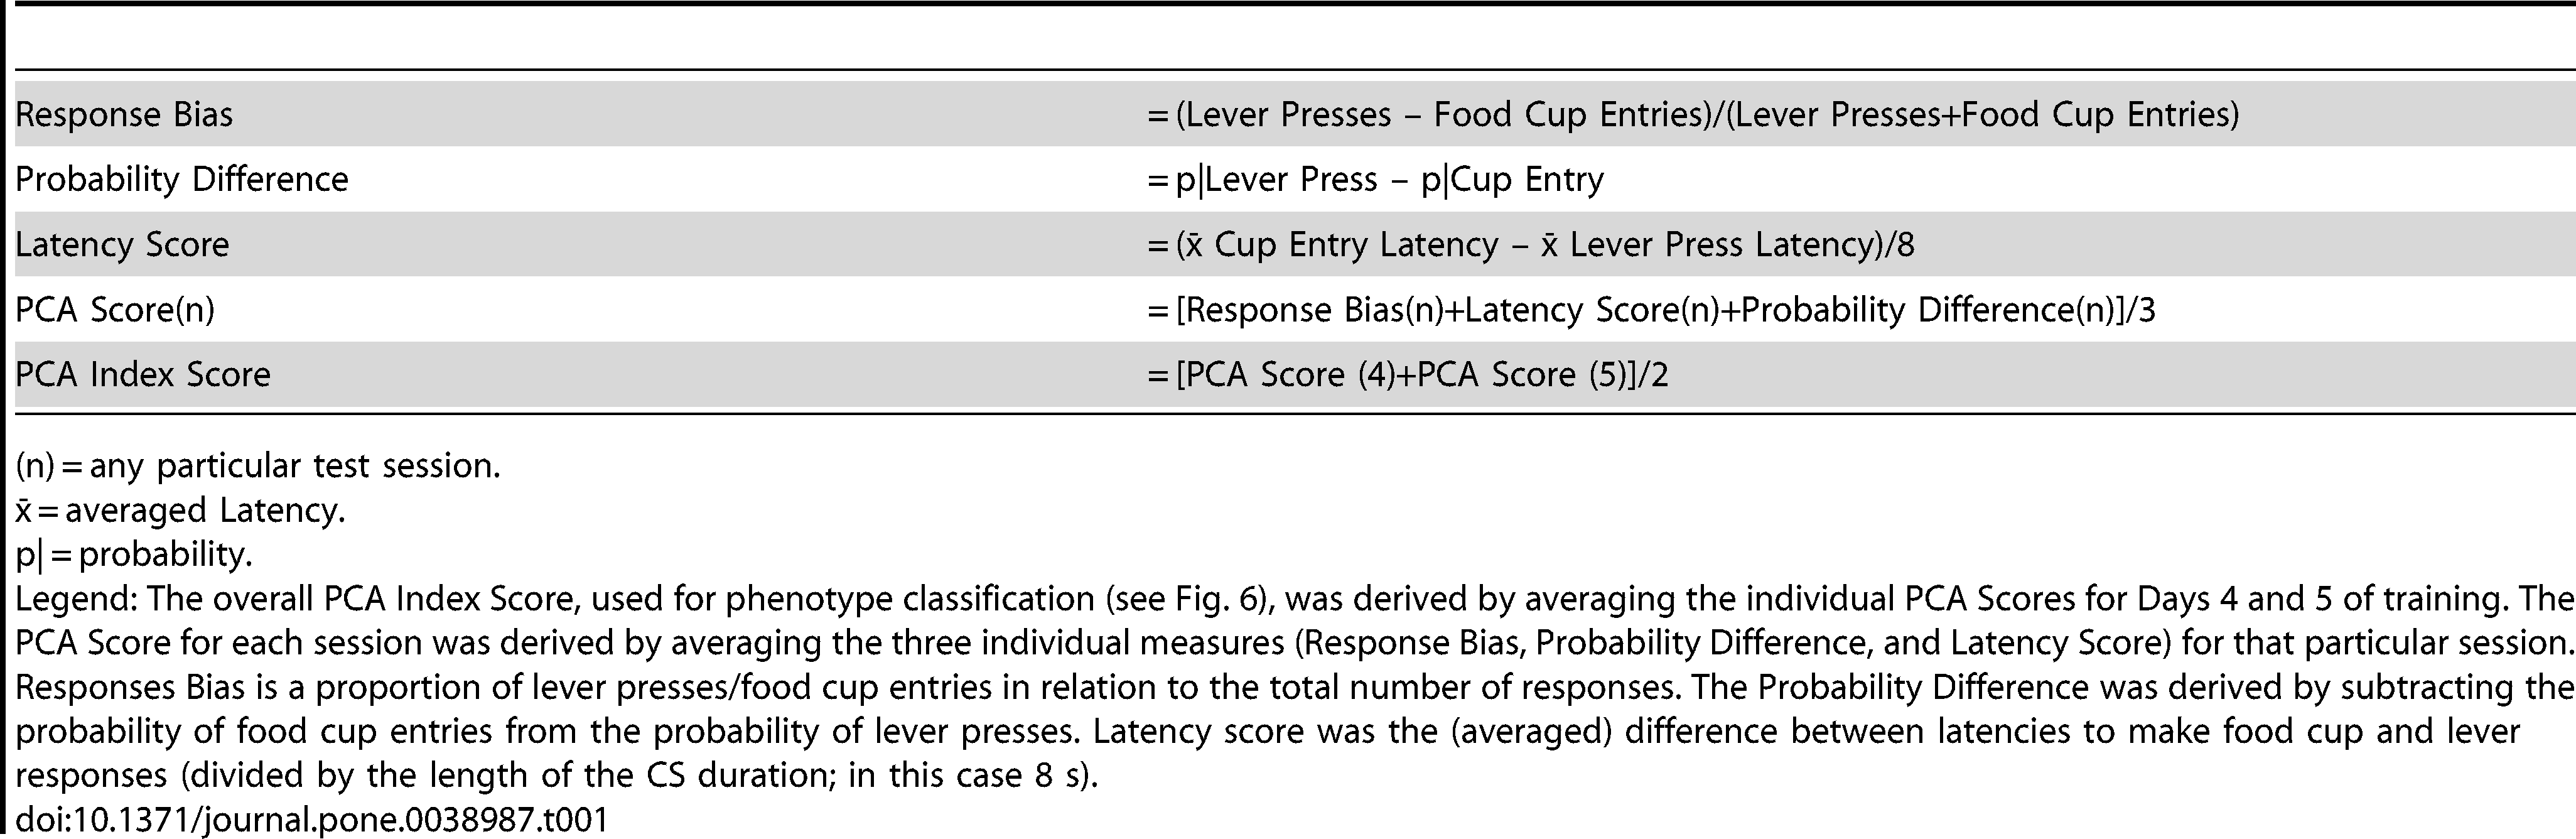

In [53]:
#meta columns
meta_params = ['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever']
#get meta data
final_data_sessions = final_data_trials.groupby(meta_params).count()['trial_num'].reset_index()

#compute lever presses, food entries, response bias
final_data_sessions['lever_press_sum'] = final_data_trials.groupby(meta_params)['active_lever_count'].sum().reset_index(name='active_lever_count')['active_lever_count']
final_data_sessions['food_entry_sum'] = final_data_trials.groupby(meta_params)['HE_count'].sum().reset_index(name='HE_count')['HE_count']
final_data_sessions['response_bias'] = ((final_data_sessions['lever_press_sum'] - final_data_sessions['food_entry_sum']) / (final_data_sessions['lever_press_sum'] + final_data_sessions['food_entry_sum'])).reset_index(name='response_bias')['response_bias']

#compute count of trials with at least 1 lever press, head entry; compute response probs
lever_press_trial_count = final_data_trials[final_data_trials['active_lever_count'] != 0].groupby(meta_params)['active_lever_count'].count().reset_index(name='lever_press_trial_count')
head_entry_trial_count = final_data_trials[final_data_trials['HE_count'] != 0].groupby(meta_params)['HE_count'].count().reset_index(name='head_entry_trial_count')
final_data_sessions = pd.merge(final_data_sessions, lever_press_trial_count, how='left', on=meta_params)
final_data_sessions = pd.merge(final_data_sessions, head_entry_trial_count, how='left', on=meta_params).replace(np.nan, 0)
final_data_sessions['lever_press_prob'] = (final_data_sessions['lever_press_trial_count'] / 25).replace(np.nan, 0)
final_data_sessions['head_entry_prob'] = (final_data_sessions['head_entry_trial_count'] / 25).replace(np.nan, 0)
final_data_sessions['prob_diff'] = final_data_sessions['lever_press_prob'] - final_data_sessions['head_entry_prob']

#compute latency diffs
final_data_sessions['lever_press_lat'] = final_data_trials.groupby(meta_params)['active_lever_latency_1st'].mean().reset_index(name='lever_latency_mean')['lever_latency_mean']
final_data_sessions['food_entry_lat'] = final_data_trials.groupby(meta_params)['HE_latency_1st'].mean().reset_index(name='HE_latency_mean')['HE_latency_mean']
final_data_sessions['latency_score'] = ((final_data_sessions['food_entry_lat'] - final_data_sessions['lever_press_lat'])/10).reset_index(name='latency_score')['latency_score']

#compute PCA score
final_data_sessions['PCA_score_3'] = (final_data_sessions['response_bias'] + final_data_sessions['prob_diff'] + final_data_sessions['latency_score']) / 3
final_data_sessions['PCA_score_2'] = (final_data_sessions['response_bias'] + final_data_sessions['prob_diff']) / 2

#add column for round
final_data_sessions['round'] = [1 if x < 1200 else 2 for x in final_data_sessions['animal'].astype('int')]

#add column for PCA group - based on PCA_score from last 2 sessions
PCA_56 = final_data_sessions[final_data_sessions['session'].isin(['6', '7'])].groupby(['part', 'group', 'animal'])['PCA_score_2'].mean().reset_index(name='PCA_56')
PCA_56['PCA_group'] = ['ST' if x >= 0.25 else 'GT' if x <= -0.25 else 'Int' for x in PCA_56['PCA_56']]
final_data_sessions = pd.merge(final_data_sessions, PCA_56, how='left', on=['part', 'animal', 'group'])

print(final_data_sessions.shape)
final_data_sessions.head()

(420, 25)


,task,part,date,session,cage,animal,group,active_lever,trial_num,lever_press_sum,food_entry_sum,response_bias,lever_press_trial_count,head_entry_trial_count,lever_press_prob,head_entry_prob,prob_diff,lever_press_lat,food_entry_lat,latency_score,PCA_score_3,PCA_score_2,round,PCA_56,PCA_group
0,PCA,ITI,210315,1,SA319,1215,4,right,24,0,98,-1.0,0.0,23.0,0.0,0.92,-0.92,NaN,7.961304,NaN,NaN,-0.96,2,-0.98,GT
1,PCA,ITI,210315,1,SA319,1216,4,right,24,0,84,-1.0,0.0,24.0,0.0,0.96,-0.96,NaN,10.317500,NaN,NaN,-0.98,2,-0.97,GT
2,PCA,ITI,210315,1,SA319,1217,4,right,24,0,132,-1.0,0.0,24.0,0.0,0.96,-0.96,NaN,10.599167,NaN,NaN,-0.98,2,-0.97,GT
3,PCA,ITI,210315,1,SA321,1221,4,left,24,0,67,-1.0,0.0,22.0,0.0,0.88,-0.88,NaN,13.427273,NaN,NaN,-0.94,2,-0.98,GT
4,PCA,ITI,210315,1,SA321,1222,4,left,24,0,80,-1.0,0.0,23.0,0.0,0.92,-0.92,NaN,16.996087,NaN,NaN,-0.96,2,-0.98,GT


In [54]:
final_data_sessions.columns.values
final_data_sessions_tidy = final_data_sessions.drop(['task', 'date', 'cage', 'trial_num'], axis=1)
final_data_sessions_tidy_melt = final_data_sessions_tidy.set_index(['part', 'group', 'animal', 'active_lever', 'session']).unstack(-1).reset_index()
final_data_sessions_tidy_melt

part group animal active_lever lever_press_sum                       food_entry_sum                               response_bias                                                             lever_press_trial_count                               head_entry_trial_count                                     lever_press_prob                                     head_entry_prob                                     prob_diff                                     lever_press_lat                                                                 food_entry_lat                                                                latency_score                                                             PCA_score_3                                                             PCA_score_2                                                             round                      PCA_56                                                             PCA_group                              
session                                                 1  2   3  4   5   6   7              1    2    3    4    5    6    7             1         2         3         4         5         6         7                       1    2    3    4    5    6    7                      1     2     3     4     5     6     7                1     2     3     4     5     6     7               1     2     3     4     5     6     7         1     2     3     4     5     6     7               1          2        3          4          5          6          7              1          2          3         4         5         6          7             1         2         3         4         5         6         7           1         2         3         4         5         6         7           1         2         3         4         5         6         7     1  2  3  4  5  6  7         1         2         3         4         5         6         7         1    2    3    4    5    6    7
0           ITI     4   1116        right               0  0   0  0   0   0   0             58   42   50   54   69   58   43     -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000                     0.0  0.0  0.0  0.0  0.0  0.0  0.0                   23.0  23.0  24.0  24.0  23.0  24.0  24.0             0.00  0.00  0.00  0.00  0.00  0.00  0.00            0.92  0.92  0.96  0.96  0.92  0.96  0.96     -0.92 -0.92 -0.96 -0.96 -0.92 -0.96 -0.96             NaN        NaN      NaN        NaN        NaN        NaN        NaN      12.807826   7.888696   4.970000  3.177500  5.324783  7.236250   2.647083           NaN       NaN       NaN       NaN       NaN       NaN       NaN         NaN       NaN       NaN       NaN       NaN       NaN       NaN   -0.960000 -0.960000 -0.980000 -0.980000 -0.960000 -0.980000 -0.980000     1  1  1  1  1  1  1 -0.980000 -0.980000 -0.980000 -0.980000 -0.980000 -0.980000 -0.980000        GT   GT   GT   GT   GT   GT   GT
1           ITI     4   1117        right               0  0   0  1  17  10  11            108   65   71   48   57  124   89     -1.000000 -1.000000 -1.000000 -0.959184 -0.540541 -0.850746 -0.780000                     0.0  0.0  0.0  1.0  5.0  6.0  7.0                   24.0  24.0  24.0  24.0  24.0  24.0  24.0             0.00  0.00  0.00  0.04  0.20  0.24  0.28            0.96  0.96  0.96  0.96  0.96  0.96  0.96     -0.96 -0.96 -0.96 -0.92 -0.76 -0.72 -0.68             NaN        NaN      NaN  44.490000  33.214000  28.723333  47.425714       4.964167   3.790417   1.600000  1.647083  1.275417  0.808750   0.971667           NaN       NaN       NaN -4.284292 -3.193858 -2.791458 -4.645405         NaN       NaN       NaN -2.054492 -1.498133 -1.454068 -2.035135   -0.980000 -0.980000 -0.980000 -0.939592 -0.650270 -0.785373 -0.730000     1  1  1  1  1  1  1 -0.757687 -0.757687 -0.757687 -0.757687 -0.757687 -0.757687 -0.757687        GT   GT   GT   GT   GT   GT   GT
2           ITI     4   1118        right               0  0   0  0   0   0   0             42   57   60   81  127   60

In [55]:
final_data_trials.to_csv('PCA_trial.csv', index=False)
final_data_sessions.to_csv('PCA_session.csv', index=False)
final_data_sessions_tidy_melt.to_csv('PCA_melt.csv', index=False)

### Viz

In [56]:
final_data_sessions.head(1)

,task,part,date,session,cage,animal,group,active_lever,trial_num,lever_press_sum,food_entry_sum,response_bias,lever_press_trial_count,head_entry_trial_count,lever_press_prob,head_entry_prob,prob_diff,lever_press_lat,food_entry_lat,latency_score,PCA_score_3,PCA_score_2,round,PCA_56,PCA_group
0,PCA,ITI,210315,1,SA319,1215,4,right,24,0,98,-1.0,0.0,23.0,0.0,0.92,-0.92,NaN,7.961304,NaN,NaN,-0.96,2,-0.98,GT


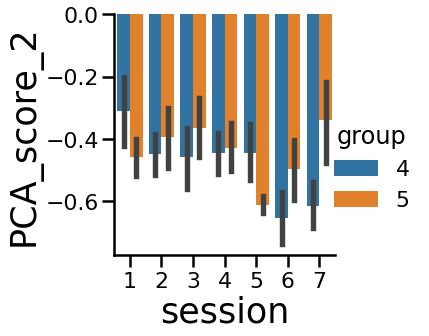

In [58]:
final_data_sessions_wi = final_data_sessions[final_data_sessions['part'] == 'within']

exclude_no_100 = [1116, 1217, 1221, 1222, 1236, 1239, 1240]

final_data_sessions_wi_exclude = final_data_sessions_wi[~final_data_sessions_wi['animal'].isin(exclude_no_100)]

sns.catplot(x='session', y='PCA_score_2', data=final_data_sessions_wi_exclude, hue='group', kind='bar', ci=68)

plt.show()

### Single for refactor

In [ ]:
file = file_paths[5]
print('file_path:', '\n', file, '\n')

#proccess file
task, session, animal, date = get_file_info_common(file)
print('date:', date, 'animal:', animal, 'task:', task, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E:", "T:")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_PCA(events_and_times, 22, 5, 15, 16)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times, 'within')
print(trial_data.head(), '\n')

ITI_trial_data = create_trial_df(events_and_times, trial_times, 'ITI')
print(ITI_trial_data.head(), '\n')

bit_dic = {'right_lever': 1, 'left_lever': 2, 'HE': 6, 'right_lever_CS': 26, 'left_lever_CS': 27, 'HE_CS': 24}
session_data = create_session_df_PCA(trial_data, bit_dic, 'within')

ITI_dic = {'right_lever': 1, 'left_lever': 2, 'HE': 6, 'right_lever_ITI': 28, 'left_lever_ITI': 29, 'HE_ITI': 25}
ITI_data = create_session_df_PCA(ITI_trial_data, ITI_dic, 'ITI')